## Question 1: **Answer**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
def add_data_to_database(data):
    try:
        # Creating a DataFrame
        df = pd.read_csv(data)
        # Connecting to database
        engine = sqlite3.connect("customer_behavior_data.db")
        df.to_sql("customers", con=engine, index = False)
        engine.close()
    except Exception as e:
            print(f'Error: {e}')

# Loading data
data = "/content/customer_behavior_data.csv"
add_data_to_database(data)

In [3]:
# Loading Magic extension
%load_ext sql

In [4]:
# Connecting to the database
%sql sqlite:///customer_behavior_data.db

In [5]:
# Default to duplicated style
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [6]:
%%sql
SELECT * FROM customers
LIMIT 5;

 * sqlite:///customer_behavior_data.db
Done.


id,age,gender,income,education,region,loyalty_status,purchase_frequency,purchase_amount,product_category,promotion_usage,satisfaction_score
1,27,Male,40682,Bachelor,East,Gold,frequent,18249,Books,0,6
2,29,Male,15317,Masters,West,Regular,rare,4557,Clothing,1,6
3,37,Male,38849,Bachelor,West,Silver,rare,11822,Clothing,0,6
4,30,Male,11568,HighSchool,South,Regular,frequent,4098,Food,0,7
5,31,Female,46952,College,North,Regular,occasional,19685,Clothing,1,5


## Question 2: **Answer**

In [7]:
%%sql
SELECT
    loyalty_status,
    COUNT(*) AS churn_risk_count
FROM customers
WHERE satisfaction_score <= 3
GROUP BY loyalty_status
ORDER BY churn_risk_count DESC;

 * sqlite:///customer_behavior_data.db
Done.


loyalty_status,churn_risk_count
Regular,3965
Silver,1971
Gold,635


## Question 3: **Answers**

In [8]:
%%sql
SELECT
    with_promotion.total_sales AS total_sales_with_promo,
    without_promotion.total_sales AS total_sales_no_promo,
    -- Finding the difference
    ABS(with_promotion.total_sales - without_promotion.total_sales) AS
    difference
FROM
    -- calculates total sales for customers who used a promotion
    (SELECT
        loyalty_status,
        SUM(purchase_amount) AS total_sales,
        promotion_usage
    FROM customers
    WHERE promotion_usage = 1
        AND loyalty_status = 'Gold'
    GROUP BY loyalty_status
    ) AS with_promotion
JOIN
    -- calculates total sales for customers who did not used a promotion
    (SELECT
        loyalty_status,
        SUM(purchase_amount) AS total_sales,
        promotion_usage
    FROM customers
    WHERE promotion_usage = 0
        AND loyalty_status = 'Gold'
    GROUP BY loyalty_status
    ) AS without_promotion
ON with_promotion.loyalty_status = without_promotion.loyalty_status;

 * sqlite:///customer_behavior_data.db
Done.


total_sales_with_promo,total_sales_no_promo,difference
28196351,67037133,38840782


## Part B: **Answer**

In [9]:
query = """
SELECT
    with_promotion.total_sales AS total_sales_with_promo,
    without_promotion.total_sales AS total_sales_no_promo
FROM
    (SELECT -- calculates total sales for customers who used promotion
        loyalty_status,
        SUM(purchase_amount) AS total_sales,
        promotion_usage
    FROM customers
    WHERE promotion_usage = 1
        AND loyalty_status = 'Gold'
    GROUP BY loyalty_status
    ) AS with_promotion
JOIN
    (SELECT
        loyalty_status,
        SUM(purchase_amount) AS total_sales,
        promotion_usage
    FROM customers
    WHERE promotion_usage = 0
        AND loyalty_status = 'Gold'
    GROUP BY loyalty_status
    ) AS without_promotion
ON with_promotion.loyalty_status = without_promotion.loyalty_status;

"""

In [10]:
# Connecting to the database and loading data into a DataFrame
connection = sqlite3.connect('customer_behavior_data.db')
df = pd.read_sql_query(query, connection)

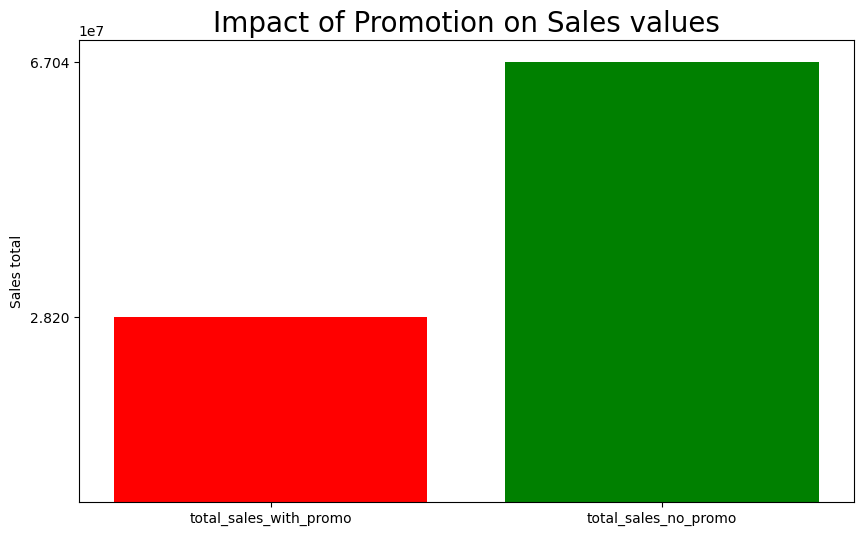

In [11]:
# Creating a plot with matplotlib
values = [
    df.loc[0, 'total_sales_with_promo'],
    df.loc[0, 'total_sales_no_promo']
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df.columns, df.loc[0],
       color = ['Red', 'Green'],
       label = df.loc[0])
ax.set_yticks(values)
ax.set_ylabel("Sales total")
plt.title('Impact of Promotion on Sales values', fontsize = 20)
plt.show()

## Question 4: **Answer**

In [12]:
%%sql
SELECT
-- Count customers with above average score
    SUM(CASE
            WHEN c.satisfaction_score > (SELECT AVG(satisfaction_score)
            FROM customers) THEN 1
            ELSE 0
        END) AS above_average_count,

-- Count customers with below average score
    SUM(CASE
            WHEN c.satisfaction_score < (SELECT AVG(satisfaction_score)
            FROM customers) THEN 1
            ELSE 0
        END) AS below_average_count
FROM customers c
WHERE c.loyalty_status = 'Regular';

 * sqlite:///customer_behavior_data.db
Done.


above_average_count,below_average_count
18666,41472


## Question 5: **Answer**

In [13]:
%%sql
WITH categorized_customers AS (
    SELECT
        CASE
            WHEN age >= 30 THEN '30_and_above'
            ELSE 'Below_30'
        END AS categorized_age_group,
        CASE
            WHEN education IN ('Bachelor','Masters', 'College')
            THEN 'College educated'
            ELSE 'Not college educated'
        END AS education_status,
        SUM(purchase_amount) AS total_electronic_purchase
    FROM customers
    WHERE LOWER(product_category) = 'electronics'
    GROUP BY categorized_age_group, education_status
)
SELECT
    categorized_age_group,
    education_status,
    printf('%20s', total_electronic_purchase) AS total_electronic_purchase
FROM categorized_customers
WHERE total_electronic_purchase = (SELECT MAX(total_electronic_purchase)
                                    FROM categorized_customers);

 * sqlite:///customer_behavior_data.db
Done.


categorized_age_group,education_status,total_electronic_purchase
30_and_above,College educated,126622806


## Question 6: **Answer**

In [14]:
%%sql
-- Ranking customers within loyalty status
WITH customer_spending AS (
    SELECT
        id,
        loyalty_status,
        SUM(purchase_amount) AS total_spent,
        RANK() OVER (PARTITION BY loyalty_status
        ORDER BY SUM(purchase_amount) DESC) AS spending_rank
    FROM customers
    GROUP BY id, loyalty_status
)
-- Retrieve top spender within each loyalty status
SELECT
    id,
    loyalty_status,
    total_spent
FROM customer_spending
WHERE spending_rank = 1;

 * sqlite:///customer_behavior_data.db
Done.


id,loyalty_status,total_spent
83256,Gold,24408
72792,Regular,25406
91490,Silver,26204
